# KDE Gaussians

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
import os
import sys

from scipy.stats import gaussian_kde, multivariate_normal
from sklearn.mixture import GaussianMixture

In [2]:
# IMPORT Z SPACE DATA

catalog_name = 'SculptorInSextans'

path = catalog_name+'_8deg/'
savepath = path+'Figaro_outputs/'

if not os.path.exists(savepath):
    os.makedirs(savepath)

z_train = pd.read_csv(path+catalog_name+'_z_train_region.csv')
z_train = z_train.drop(columns=['Unnamed: 0'])

X_test = pd.read_csv(path+catalog_name+'_X_test_4deg_region.csv')
z_test = pd.read_csv(path+catalog_name+'_z_test_4deg_region.csv')
z_test = z_test.drop(columns=['Unnamed: 0'])
z_test.head(10)

# THEORETICAL NORMALIZED GAUSSIAN DISTRIBUTION
mean = 0
std_dev = 1
norm_train = np.linspace(-5, 5, z_train.shape[0])
norm_test = np.linspace(-5, 5, z_test.shape[0])
y_norm_train = multivariate_normal.pdf(norm_train, mean, std_dev)
y_norm_test = multivariate_normal.pdf(norm_test, mean, std_dev)

z_test.head()

,source_id,Xi,Xn,PMra,PMdec,BP0-RP0,G0_c,pmra_error,pmdec_error,bp_rp_error,phot_g_mean_mag_err,phot_bp_mean_mag_err,phot_rp_mean_mag_err
0,42,0.506135,0.511146,0.168856,0.968670,0.353941,-0.831292,0.046005,0.047857,0.306743,0.011499,0.021656,0.013236
1,42,0.492262,0.507918,0.154351,0.943295,0.364010,-0.931363,0.044330,0.050151,0.306636,0.010303,0.021047,0.013002
2,42,0.513604,0.516493,1.076739,1.551735,0.191039,0.114096,0.127675,0.116830,0.317555,0.057223,0.059695,0.041731
3,42,0.525653,0.504465,0.450303,1.281795,-0.417467,0.890328,0.154806,0.133301,0.318696,0.076125,0.073138,0.050942
4,42,0.513119,0.482172,-0.053594,-0.004931,-3.739336,-0.156970,0.234914,0.229835,0.295862,0.128198,0.077367,0.106096


In [3]:
# TAKING THE MEMNBER INDICES
members_indices = np.where(z_test['source_id'] == 42)[0]
nonmembers_indices = np.where(z_test['source_id'] != 42)[0]

print('Number of members:', len(members_indices))
print('Number of non-members:', len(nonmembers_indices))

Number of members: 6354
Number of non-members: 52988


In [13]:
# Filter rows where 'source_id' is different from 42
non_members = z_test[z_test['source_id'] != 42]

# Select 40,000 rows to drop
rows_to_drop = non_members.sample(n=40000, random_state=42).index

# Drop the selected rows
z_test = z_test.drop(index=rows_to_drop).reset_index(drop=True)

print(f"New shape of z_test: {z_test.shape}")

# TAKING THE MEMNBER INDICES
members_indices = np.where(z_test['source_id'] == 42)[0]
nonmembers_indices_new = np.where(z_test['source_id'] != 42)[0]

print('Number of members:', len(members_indices))
print('Number of non-members:', len(nonmembers_indices_new))

New shape of z_test: (19342, 13)
Number of members: 6354
Number of non-members: 12988


## Plot Functions

In [14]:
def confusion_matrix(df, members_indices, nonmembers_indices, members_threshold=0.5, nonmembers_threshold=0.5):
    TP = np.where((df['source_id']==42) & (df['posterior_prob'] < members_threshold))[0]
    TN = np.where((df['source_id']!=42) & (df['posterior_prob'] > nonmembers_threshold))[0]
    FP = np.where((df['source_id']!=42) & (df['posterior_prob'] < nonmembers_threshold))[0]
    FN = np.where((df['source_id']==42) & (df['posterior_prob'] > members_threshold))[0]

    return TP, TN, FP, FN


def confusion_plots_latex(df, TP, FP, FN, TN, members, non_members):

    print('TP: ', len(TP))
    print('FP: ', len(FP))
    print('FN: ', len(FN))
    print('TN: ', len(TN))
  

    confusion_dict = {'TP': TP, 'FP': FP, 'FN': FN, 'TN': TN}
    confusion_type = ['TP', 'FP', 'FN', 'TN']

    fig, ax = plt.subplots(4, 3, figsize=(15, 20))
    #fig.suptitle(f'Confusion plots UMAP: thresholds {memb_thr} - {nonmemb_thr}; members={members.shape[0]} non members={non_members.shape[0]}', fontsize=20)
    for i in range(4):

        if confusion_type[i] == 'TP' or confusion_type[i] == 'FN':
            ax[i, 0].scatter(df['Xi'], df['Xn'], s=5, alpha=0.3, c='grey')
            ax[i, 0].scatter(df.loc[confusion_dict[confusion_type[i]], ['Xi']], df.loc[confusion_dict[confusion_type[i]], ['Xn']], s=10, c='red',
                             label=f'{confusion_type[i]}: {len(confusion_dict[confusion_type[i]])} - {len(confusion_dict[confusion_type[i]])/len(members)*100:.2f}%')
            ax[i, 0].set_xlabel('Xi')
            ax[i, 0].set_ylabel('Xn')
            ax[i, 0].legend(loc='upper left')

            ax[i, 1].scatter(df['PMra'], df['PMdec'], s=5, alpha=0.3, c='grey')
            ax[i, 1].scatter(df.loc[confusion_dict[confusion_type[i]], ['PMra']], df.loc[confusion_dict[confusion_type[i]], ['PMdec']], s=10, c='red')
            ax[i, 1].set_xlabel('pmra')
            ax[i, 1].set_ylabel('pmdec')

            ax[i, 2].scatter(df['BP0-RP0'], df['G0_c'], s=5, alpha=0.3, c='grey')
            ax[i, 2].scatter(df.loc[confusion_dict[confusion_type[i]], ['BP0-RP0']], df.loc[confusion_dict[confusion_type[i]], ['G0_c']], s=10, c='red')
            ax[i, 2].invert_yaxis()
            ax[i, 2].set_xlabel('BP0-RP0')
            ax[i, 2].set_ylabel('G0_c')

        else:

            ax[i, 0].scatter(df['Xi'], df['Xn'], s=5, alpha=0.3, c='grey')
            ax[i, 0].scatter(df.loc[confusion_dict[confusion_type[i]], ['Xi']], df.loc[confusion_dict[confusion_type[i]], ['Xn']], s=10, c='red',
                             label=f'{confusion_type[i]}: {len(confusion_dict[confusion_type[i]])} - {len(confusion_dict[confusion_type[i]])/len(non_members)*100:.2f}%')
            ax[i, 0].set_xlabel('Xi')
            ax[i, 0].set_ylabel('Xn')
            ax[i, 0].legend(loc='upper left')

            ax[i, 1].scatter(df['PMra'], df['PMdec'], s=5, alpha=0.3, c='grey')
            ax[i, 1].scatter(df.loc[confusion_dict[confusion_type[i]], ['PMra']], df.loc[confusion_dict[confusion_type[i]], ['PMdec']], s=10, c='red')
            ax[i, 1].set_xlabel('pmra')
            ax[i, 1].set_ylabel('pmdec')

            ax[i, 2].scatter(df['BP0-RP0'], df['G0_c'], s=5, alpha=0.3, c='grey')
            ax[i, 2].scatter(df.loc[confusion_dict[confusion_type[i]], ['BP0-RP0']], df.loc[confusion_dict[confusion_type[i]], ['G0_c']], s=10, c='red')
            ax[i, 2].invert_yaxis()
            ax[i, 2].set_xlabel('BP0-RP0')
            ax[i, 2].set_ylabel('G0_c')

    #plt.tight_layout()
    #plt.show()

    return fig


In [15]:
def kde_gauss(z_selection, mu_bg, cov_bg, uniform_alpha=0.0, Nbg=6000):

    # PRIOR
    print('Nbg:',Nbg)
    Ndata = z_selection.shape[0]
    Pbg = Nbg / Ndata # Probability of a stars to belong to the background. In your case you can have it from surface density of the bakcground multiply by the volume
    Pgal = 1 - Pbg

    # ADDITIONAL Uniform Uniform background likelihood
    a, b = -4, 4  # Uniform bounds in each dimension
    volume = (b - a)**4  # Volume of the 4D uniform distribution
    uniform_likelihood = 1 / volume

    # KDE GAussian for entire dataset     
    kde = gaussian_kde(z_selection.T, bw_method='silverman')
    
    # Posterior function using Bayes theorem P(bg|x)=( P(x|bg) * Pbg ) / P(x)
    def posterior_bg(data):

        # Likelihood for BG population : P(x|bg)
        likelihood_bg = multivariate_normal.pdf(data, mean=mu_bg, cov=cov_bg)

        # Combined likelihood with uniform background
        combined_likelihood = (1 - uniform_alpha) * likelihood_bg + uniform_alpha * uniform_likelihood

        # Marginal probability: P(x)
        marginal = kde(data.T)  # Corrected GMM input
        # Posterior probability of belonging to BG: P(bg|x). This is what we abusively refer to probability of each star to belong to the background
        posterior = (combined_likelihood * Pbg) / marginal

        return np.clip(posterior, 0, 1)  # Ensure probability is between 0 and 1
    

    # Compute posterior probabilities for BG and GAL (for each point in the dataset)
    posterior_Pbg = posterior_bg(z_selection.values)
    
    # P(gal|x). This is what we abusively refer to probability of each star to belong to the galaxy.
    # This is 1- P(bg|x) since you have a bimodal distribution
    posterior_Pgal = 1 - posterior_Pbg

    return posterior_Pbg, posterior_Pgal

## BIMODAL GAUSSIAN z_test

In [19]:
# BIMODAL GAUSSIAN FOR ALL z_test
probability_table = z_test.copy()

z_test_selection = z_test[['PMra','PMdec','BP0-RP0','G0_c']]
mu_bg = np.mean(z_train[['PMra','PMdec','BP0-RP0','G0_c']], axis=0)
cov_bg = np.cov(z_train[['PMra','PMdec','BP0-RP0','G0_c']].T)

print('mu_bg:', mu_bg)
print('cov_bg:', cov_bg)

posterior_BG, posterior_GAL = kde_gauss(z_test_selection, mu_bg=mu_bg, cov_bg=cov_bg, Nbg=len(nonmembers_indices_new))

probability_table['posterior_prob'] = posterior_BG
probability_table['Pgal'] = posterior_GAL

print(probability_table)

mu_bg: PMra      -0.017920
PMdec     -0.119155
BP0-RP0   -0.130018
G0_c       0.172336
dtype: float64
cov_bg: [[ 0.97595763  0.02451072 -0.01686608  0.00166694]
 [ 0.02451072  1.08901177  0.06461391 -0.06280981]
 [-0.01686608  0.06461391  1.00782709 -0.07794867]
 [ 0.00166694 -0.06280981 -0.07794867  1.1261662 ]]
Nbg: 12988
                 source_id        Xi        Xn      PMra     PMdec   BP0-RP0  \
0                       42  0.506135  0.511146  0.168856  0.968670  0.353941   
1                       42  0.492262  0.507918  0.154351  0.943295  0.364010   
2                       42  0.513604  0.516493  1.076739  1.551735  0.191039   
3                       42  0.525653  0.504465  0.450303  1.281795 -0.417467   
4                       42  0.513119  0.482172 -0.053594 -0.004931 -3.739336   
...                    ...       ...       ...       ...       ...       ...   
19337  5745107791690659200  0.317416  0.430493 -0.012420  0.639318 -0.373029   
19338  5745107791690778368  0.3173

TP:  5369
FP:  8578
FN:  985
TN:  4410


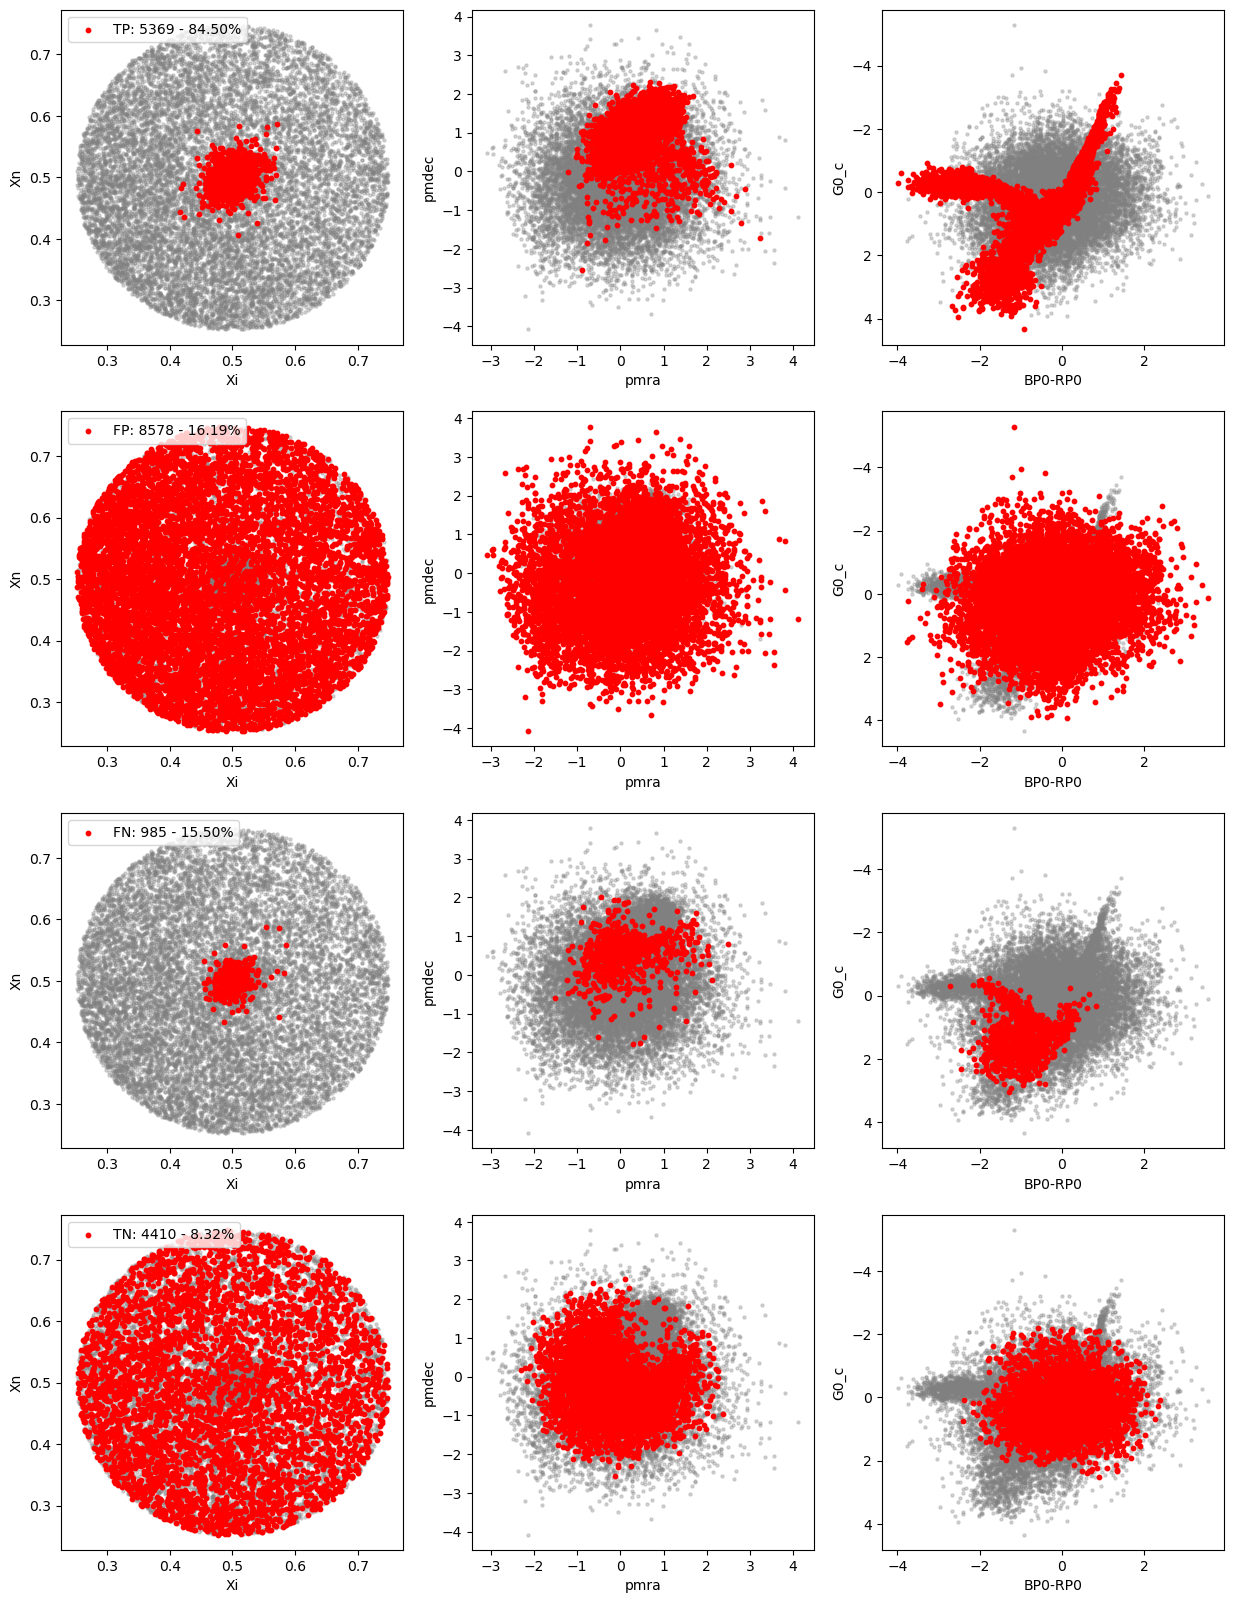

In [20]:
TP, TN, FP, FN = confusion_matrix(probability_table, members_indices, nonmembers_indices_new, members_threshold=0.2, nonmembers_threshold=0.95)

fig = confusion_plots_latex(probability_table, TP, FP, FN, TN, members_indices, nonmembers_indices)